# Plot comparison between $M_0$ and Local cumulative slip and the slip velocity

Plot the comparison between the magnitude and the local cumulative slip.

2025.01.28 Kurama Okubo

- 2025.03.19 update for master plot

In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import matplotlib as mpl
import matplotlib.ticker as mticker

%matplotlib inline
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from tqdm import tqdm
import warnings
import time
import pickle 
import seaborn as sns
import copy

import scipy.io as sio
from scipy.signal import decimate

%load_ext autoreload
%autoreload 2

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 10
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = True

plt.rcParams["savefig.transparent"] = False #True


In [2]:
figdir = "../figure/05_M0andslip_slipvel_masterplot/"
if not os.path.exists(figdir):
    os.makedirs(figdir)


# List of plots
1. 16 slip sensors with the timing of gouge event
2. Time history of the slip at gouge patch
3. Scatter plot of M0 vs cumulative local slip

In [3]:
expr_id = 87

# Load the event catalog

In [4]:
df_gougeevent = pd.read_csv(f"../data/localslip_and_slipvel_fb03-{expr_id:03d}.csv")

In [5]:
df_gougeevent.head()

,event_id,location,event_onset_time,stickslip_id,event_label,Q_correction_quart,Nvalidsensors,M0,M0_std,Mw,Tw,Tw_std,cumulativelocalslip[mm],localslipvelocity[mm/s]
0,4,1.75,42.474772,3,A,50,4,0.592607,0.178671,-6.218156,0.000003,1.530315e-07,0.021109,1.134615
1,9,1.75,47.662693,5,F,50,4,0.046991,0.007419,-6.951990,0.000002,3.643121e-07,0.001041,1.723430
2,18,1.75,56.727044,8,F,50,4,0.755830,0.192507,-6.147717,0.000003,3.100882e-07,0.002639,2.894185
3,19,1.75,59.103175,9,F,50,4,0.055755,0.016951,-6.902476,0.000002,2.699155e-07,0.001132,2.434580
4,20,1.75,59.103526,9,F,50,4,0.865466,0.210250,-6.108500,0.000003,1.352659e-07,0.002116,3.092838


In [6]:
df_gougeevent_foreshock = df_gougeevent[df_gougeevent["event_label"]=="F"]

# 1. Plot space and slip

In [7]:
lc = sns.color_palette("colorblind", as_cmap=False)
lc

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [8]:
figdir_space = "../figure/05_M0andslip_slipvel_masterplot/spatialslip_M0"
if not os.path.exists(figdir_space):
    os.makedirs(figdir_space)
    

## Plot representive event

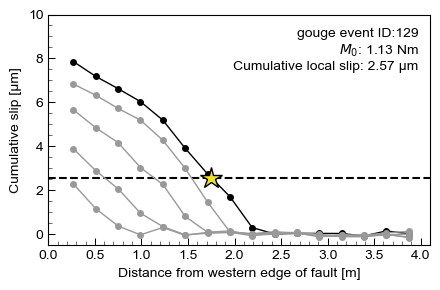

In [9]:
# for ind, df_event in df_gougeevent_foreshock.iterrows():
masterevent_id = 129
df_event = df_gougeevent_foreshock[df_gougeevent_foreshock["event_id"]==masterevent_id].iloc[0]
stickslip_id = df_event.stickslip_id
gougeevent_id = df_event.event_id

finame_mat = f"../data/p01_slipandslipvel/FB03-{expr_id:03d}_slipvelocity_event{stickslip_id:03d}.mat"
V = sio.loadmat(finame_mat, squeeze_me=True)

# find the closest time of the onset of gouge event
tvec = V["Tstart"] + V['tmat_slip_event']
t_gougeevent_ind = np.where(tvec >= df_event["event_onset_time"])[0][0]

fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.))

ax.plot(V['Disp_x']*1e-3, V['Dmat_event_filtered'][t_gougeevent_ind, :]*1e3, "k-", marker="o", ms=4, lw=1)

# plot the slip before and after the gouge event
t_backward = [2e-3, 6e-3, 15e-3, 25e-3]
for tb in t_backward:
    tb_ind = np.where(tvec >= df_event["event_onset_time"]-tb)[0][0]
    ax.plot(V['Disp_x']*1e-3, V['Dmat_event_filtered'][tb_ind, :]*1e3, "-", c=[0.6, 0.6, 0.6], marker="o", ms=4, lw=1)


# plot gouge event and cumulative local slip
ax.plot(df_event.location, df_event["cumulativelocalslip[mm]"]*1e3, "*", mec="k", mfc=lc[8], ms=16)
# axhline
ax.axhline(df_event["cumulativelocalslip[mm]"]*1e3, c="k", ls="--", zorder=-1)

annottxt = f"gouge event ID:{gougeevent_id}\n$M_0$: {df_event['M0']:4.2f} Nm\nCumulative local slip: {df_event['cumulativelocalslip[mm]']*1e3:4.2f} μm"
ax.text(0.97, 0.76, annottxt, transform=ax.transAxes, ha="right")

ax.set_xlim(0, 4.1)

if df_event['cumulativelocalslip[mm]'] *1e3 > 10:
    ymax = 40
else:
    ymax = 10
    
ax.set_ylim(-0.5, ymax)

ax.set_xlabel("Distance from western edge of fault [m]")
ax.set_ylabel("Cumulative slip [μm]")

plt.tight_layout()

# plt.savefig(figdir_space+f"/cumulativeslip_fb03-{expr_id:03d}_{gougeevent_id}.png", format="png", dpi=80)
plt.savefig(figdir_space+f"/FigS_cumulativeslip_fb03-{expr_id:03d}_{gougeevent_id}.eps")

# plt.clf()
# plt.close()

## Plot all the gouge event

In [10]:
for ind, df_event in df_gougeevent_foreshock.iterrows():
    
    # df_event = df_gougeevent_foreshock[df_gougeevent_foreshock["event_id"]==masterevent_id].iloc[0]
    stickslip_id = df_event.stickslip_id
    gougeevent_id = df_event.event_id

    finame_mat = f"../data/p01_slipandslipvel/FB03-{expr_id:03d}_slipvelocity_event{stickslip_id:03d}.mat"
    V = sio.loadmat(finame_mat, squeeze_me=True)
    
    # find the closest time of the onset of gouge event
    tvec = V["Tstart"] + V['tmat_slip_event']
    t_gougeevent_ind = np.where(tvec >= df_event["event_onset_time"])[0][0]
    
    fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.))
    
    ax.plot(V['Disp_x']*1e-3, V['Dmat_event_filtered'][t_gougeevent_ind, :]*1e3, "k-", marker="o", ms=4, lw=1)
    
    # plot the slip before and after the gouge event
    t_backward = [2e-3, 4e-6, 6e-3, 10e-3]
    for tb in t_backward:
        tb_ind = np.where(tvec >= df_event["event_onset_time"]-tb)[0][0]
        ax.plot(V['Disp_x']*1e-3, V['Dmat_event_filtered'][tb_ind, :]*1e3, "-", c=[0.6, 0.6, 0.6], marker="o", ms=4, lw=1)
    
    
    # plot gouge event and cumulative local slip
    ax.plot(df_event.location, df_event["cumulativelocalslip[mm]"]*1e3, "*", mec="k", mfc=lc[8], ms=16)
    # axhline
    ax.axhline(df_event["cumulativelocalslip[mm]"]*1e3, c="k", ls="--", zorder=-1)
    
    annottxt = f"gouge event ID:{gougeevent_id}\n$M_0$: {df_event['M0']:4.2f} Nm\nCumulative local slip: {df_event['cumulativelocalslip[mm]']*1e3:4.2f} μm"
    ax.text(0.85, 0.76, annottxt, transform=ax.transAxes, ha="right")
    
    ax.set_xlim(0, 4.1)
    
    if df_event['cumulativelocalslip[mm]'] *1e3 > 10:
        ymax = 40
    else:
        ymax = 10
        
    ax.set_ylim(-0.5, ymax)
    
    ax.set_xlabel("Distance from western edge of fault [m]")
    ax.set_ylabel("Cumulative slip [μm]")
    
    plt.tight_layout()
    
    plt.savefig(figdir_space+f"/cumulativeslip_fb03-{expr_id:03d}_{gougeevent_id}.jpg", format="jpg", dpi=80)
    # plt.savefig(figdir_space+f"/cumulativeslip_fb03-{expr_id:03d}_{gougeevent_id}.pdf")
    
    plt.clf()
    plt.close()

# 2. Plot time history of cumulative slip

In [11]:
figdir_tr = "../figure/05_M0andslip_slipvel_masterplot/debug_timehistory_cumulativeslip"
if not os.path.exists(figdir_tr):
    os.makedirs(figdir_tr)
    

In [12]:
for ind, df_event in df_gougeevent_foreshock.iterrows():
    # masterevent_id = 129
    # df_event = df_gougeevent_foreshock[df_gougeevent_foreshock["event_id"]==masterevent_id].iloc[0]
    stickslip_id = df_event.stickslip_id
    gougeevent_id = df_event.event_id
    
    finame_mat = f"../data/p01_slipandslipvel/FB03-{expr_id:03d}_slipvelocity_event{stickslip_id:03d}.mat"
    V = sio.loadmat(finame_mat, squeeze_me=True)
    
    # find the closest time of the onset of gouge event
    tvec = V["Tstart"] + V['tmat_slip_event']
    
    finame_tr = f"../data/p02_slipinterpolation/FB03-087_slip_and_slipvel_atgouge_gougeevent{gougeevent_id:03d}.mat"
    
    W = sio.loadmat(finame_tr, squeeze_me=True)
    
    fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.))
    ax.plot(W['tr_tmat'] - V["Tstart"], W['tr_slip_gouge']*1e3, "k-")
    
    # plot gouge event and cumulative local slip
    ax.plot(df_event.event_onset_time - V["Tstart"], df_event["cumulativelocalslip[mm]"]*1e3, "*", mec="k", mfc=lc[8], ms=16)
    # axhline
    ax.axhline(df_event["cumulativelocalslip[mm]"]*1e3, c="k", ls="--", zorder=-1)
    
    annottxt = f"gouge event ID:{gougeevent_id}\n$M_0$: {df_event['M0']:4.2f} Nm\nCumulative local slip: {df_event['cumulativelocalslip[mm]']*1e3:4.2f} μm"
    ax.text(0.9, 0.3, annottxt, transform=ax.transAxes, ha="right")
    
    ax.set_ylim(-2, 40)

    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Cumulative slip [μm]")
   
    plt.tight_layout()
    
    # plt.savefig(figdir_tr+f"/cumulativeslip_fb03-{expr_id:03d}_{gougeevent_id}.png", format="png", dpi=80)
    plt.savefig(figdir_tr+f"/timehistory_cumulativeslip_fb03-{expr_id:03d}_{gougeevent_id}.pdf")
    
    plt.clf()
    plt.close()

# 3. Scatter plot of M0 vs cumulative local slip

In [13]:
figdir_master = "../figure/05_M0andslip_slipvel_masterplot/master_scatter"
if not os.path.exists(figdir_master):
    os.makedirs(figdir_master)
    

In [14]:
# select the foreshocks with the valid sensors
Nvalidsensor_thresh = 4
df_gf_thresh = df_gougeevent_foreshock[df_gougeevent_foreshock["Nvalidsensors"]>=Nvalidsensor_thresh]

# remove the event 126 as it is on the measurement limitation
measurementlimit_list = [126]
df_gf_thresh_measurementlimit = df_gf_thresh[df_gf_thresh["event_id"].isin(measurementlimit_list)]
df_gf_thresh_droplimevent = df_gf_thresh[~(df_gf_thresh["event_id"].isin(measurementlimit_list))]

Nevent = len(df_gf_thresh)

print(f"Number of foreshocks: {Nevent}")

Number of foreshocks: 21


In [15]:
df_gf_thresh_measurementlimit

,event_id,location,event_onset_time,stickslip_id,event_label,Q_correction_quart,Nvalidsensors,M0,M0_std,Mw,Tw,Tw_std,cumulativelocalslip[mm],localslipvelocity[mm/s]
40,126,1.75,235.63152,52,F,50,4,0.017021,0.002538,-7.246006,0.000002,2.955030e-07,0.006714,1.132211


In [16]:
scatter_mc = sns.color_palette("Set1")
scatter_mc

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6)]

In [17]:
def M02Mw(M0):
    return (np.log10(M0) - 9.1) * 2.0 / 3.0 # synchronized with OpenSWPC : moment_magnitude ( m0 )

def Mw2M0(Mw):
    return 10**( 1.5 * Mw + 9.05) # synchronized with OpenSWPC : seismic_moment ( mw )
   

### Compute log fitting
As the M0 has the std, we set Y as M0 and invert it to get the logarithmic slope.

$$\log M_0 = c_0 + c_1 \log \delta $$
$$  \delta = 10 ^{-\frac{c_0}{c_1}} M_0 ^{\frac{1}{c_1}}  $$

**NOTE:** Due to the outliers, the fitting is apart from the majority of events. Thus, we do not use the fitting values, but just refer the order of magnitude in the exponential scaling between $M_0$ and $\delta$.

In [18]:
X = np.log10(df_gf_thresh["cumulativelocalslip[mm]"].values*1e3)
Y = np.log10(df_gf_thresh["M0"].values)

res = np.polynomial.polynomial.polyfit(X, Y, 1)

print(f"delta is propotional to M0^{1/res[1]:.3f}")
M0_fit = np.logspace(-2, np.log10(5))
cumslip_fit = 10**(-res[0]/res[1]) * (M0_fit ** (1/res[1]))

Xfit = np.linspace(0, 1, 10)
Yfit = np.polynomial.polynomial.polyval(Xfit, res)

delta is propotional to M0^1.592


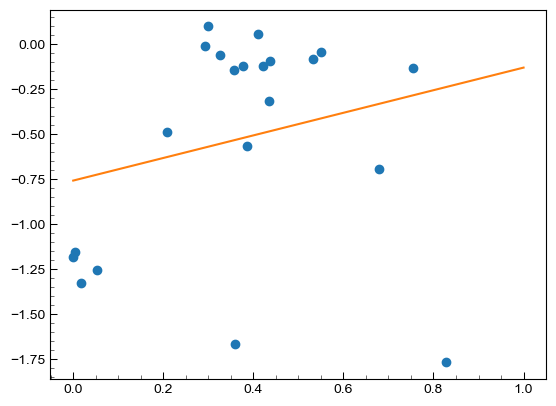

In [19]:
plt.plot(X, Y, "o")
plt.plot(Xfit, Yfit)

In [20]:
# manual fitting
M0_fit_manual = M0_fit
cumslip_fit_manual_expscaling = 0.3
cumslip_fit_manual_intercept = 2.5
cumslip_fit_manual = cumslip_fit_manual_intercept * M0_fit_manual ** cumslip_fit_manual_expscaling

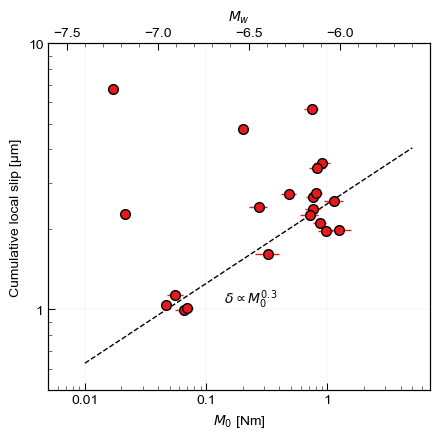

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))
mainmarkersize=7

# Compute standard error
standarderror_factor = np.sqrt(Nvalidsensor_thresh)

# # plot foreshocks
ax.errorbar(df_gf_thresh["M0"].values, df_gf_thresh["cumulativelocalslip[mm]"].values*1e3, xerr=df_gf_thresh["M0_std"].values/standarderror_factor,
           capsize=0, fmt="o", markersize=mainmarkersize, color=scatter_mc[0], lw=1, markeredgecolor = "k", label="Foreshocks", zorder=3)


# plot fit curve
# ax.plot(M0_fit, cumslip_fit, "k--")
Plotfitslope = True #True

if Plotfitslope:
    ax.plot(M0_fit_manual, cumslip_fit_manual, "k--", lw=1.0)
    annottxt = r"$\delta \propto M_0^{{{:.1f}}}$".format(cumslip_fit_manual_expscaling)
    ax.text(0.46, 0.25, annottxt, transform=ax.transAxes)

# ax.errorbar(df_gf_thresh_droplimevent["M0"].values, df_gf_thresh_droplimevent["cumulativelocalslip[mm]"].values*1e3, xerr=df_gf_thresh_droplimevent["M0_std"].values,
#            capsize=0, fmt="o", markersize=mainmarkersize, color=scatter_mc[0], lw=1, markeredgecolor = "k", label="Foreshocks", zorder=3)

# plot measurement limitation
# ax.errorbar(df_gf_thresh_measurementlimit["M0"].values, df_gf_thresh_measurementlimit["cumulativelocalslip[mm]"].values*1e3, xerr=df_gf_thresh_measurementlimit["M0_std"].values,
#            capsize=0, fmt="x", markersize=mainmarkersize, color="gray", lw=1, ls=":", markeredgecolor = "k", label="", zorder=3, alpha=1.0)



ax.set_xscale('log')
ax.set_yscale('log')


xlimit_scaling = [5e-3, 7]

ax.set_xlim(xlimit_scaling)
ax.set_ylim([0.5, 10])

# ax.set_yticks([2, 3, ])
# ax.set_yticklabels([2, 3, ])

ax.set_xlabel("$M_0$ [Nm]")
ax.set_ylabel("Cumulative local slip [μm]")

ax.grid(True, c=np.array([230, 230, 230])/255, lw=0.25, zorder=-1)
ax.set_axisbelow('True')
# ax.legend(loc=3)



#-----------------------#
#--- plot double axis---#
#-----------------------#

# https://pythonmatplotlibtips.blogspot.com/2018/01/add-second-x-axis-below-first-x-axis-python-matplotlib-pyplot.html
ax2 = ax.twiny()
ax2.set_xlabel("$M_w$")
ax2.set_xlim([M02Mw(xlimit_scaling[0]), M02Mw(xlimit_scaling[1])]) # synchronize with the first axis

# major tick
newlabel = np.array([-7.5, -7, -6.5, -6.0,])
ax2.minorticks_on()
ax2.set_xticks(newlabel)

ax.grid(True, c=np.array([230, 230, 230])/255, lw=0.25, zorder=-1)
ax.set_axisbelow('True')

ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2g'))
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))

# plt.suptitle(f'Q{Qinv_quart} water-level={k_waterlevel:.2f}', y=0.98)
plt.tight_layout()

plt.savefig(figdir_master+f"/FigS_M0_cumulativeslip_fb03-{expr_id:03d}_fitcurve{Plotfitslope}.png", format="png", dpi=70)
plt.savefig(figdir_master+f"/FigS_M0_cumulativeslip_fb03-{expr_id:03d}_fitcurve{Plotfitslope}.eps")


In [22]:
df_gf_thresh["cumulativelocalslip[mm]"].mean() * 1e3

2.6692309291272

In [23]:
# compute quartile of cumulative local slip
cumds_1 = df_gf_thresh["cumulativelocalslip[mm]"].quantile(0.25) * 1e3
cumds_3 = df_gf_thresh["cumulativelocalslip[mm]"].quantile(0.75) * 1e3
print(cumds_1, cumds_3)

1.9660262247299998 2.7417775060311


In [30]:
len(df_gf_thresh)

21

# Plot correlation to the local slip velocity

In [24]:
df_gougeevent.head()

,event_id,location,event_onset_time,stickslip_id,event_label,Q_correction_quart,Nvalidsensors,M0,M0_std,Mw,Tw,Tw_std,cumulativelocalslip[mm],localslipvelocity[mm/s]
0,4,1.75,42.474772,3,A,50,4,0.592607,0.178671,-6.218156,0.000003,1.530315e-07,0.021109,1.134615
1,9,1.75,47.662693,5,F,50,4,0.046991,0.007419,-6.951990,0.000002,3.643121e-07,0.001041,1.723430
2,18,1.75,56.727044,8,F,50,4,0.755830,0.192507,-6.147717,0.000003,3.100882e-07,0.002639,2.894185
3,19,1.75,59.103175,9,F,50,4,0.055755,0.016951,-6.902476,0.000002,2.699155e-07,0.001132,2.434580
4,20,1.75,59.103526,9,F,50,4,0.865466,0.210250,-6.108500,0.000003,1.352659e-07,0.002116,3.092838


In [25]:
df_gougeevent_foreshock_thresh = df_gougeevent[(df_gougeevent["event_label"]=="F") & (df_gougeevent["Nvalidsensors"]>=Nvalidsensor_thresh) ]
df_gougeevent_aftershock_thresh = df_gougeevent[(df_gougeevent["event_label"]=="A") & (df_gougeevent["Nvalidsensors"]>=Nvalidsensor_thresh) ]

In [26]:
# df_gougeevent_foreshock_thresh

In [27]:
# df_gougeevent_aftershock_thresh

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


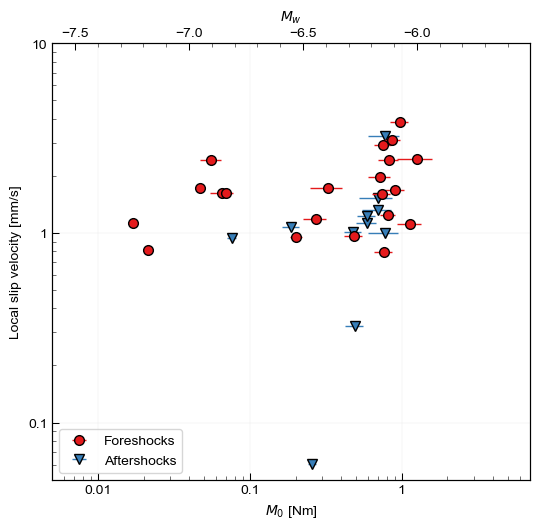

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 5.4))

mc = sns.color_palette("colorblind", as_cmap=True)
mt = ["s", "d", "v", "^"]
ms = 20


ax.errorbar(df_gougeevent_foreshock_thresh["M0"].values,  df_gougeevent_foreshock_thresh["localslipvelocity[mm/s]"].values, xerr=df_gougeevent_foreshock_thresh["M0_std"].values/standarderror_factor,
           capsize=0, fmt="o", markersize=mainmarkersize, color=scatter_mc[0], lw=1, markeredgecolor = "k", label="Foreshocks", zorder=4)

ax.errorbar(df_gougeevent_aftershock_thresh["M0"].values,  df_gougeevent_aftershock_thresh["localslipvelocity[mm/s]"].values, xerr=df_gougeevent_aftershock_thresh["M0_std"].values/standarderror_factor,
           capsize=0, fmt="v", markersize=mainmarkersize, color=scatter_mc[1], lw=1, markeredgecolor = "k", label="Aftershocks", zorder=3)



ax.set_xscale('log')
ax.set_yscale('log')


# xlimit_scaling = [5e-3, 7]

ax.set_xlim(xlimit_scaling)
ax.set_ylim([0.05, 10])

ax.legend(loc=3)

ax.set_xlabel("$M_0$ [Nm]")
ax.set_ylabel("Local slip velocity [mm/s]")

ax.grid(True, c=np.array([230, 230, 230])/255, lw=0.25, zorder=-1)
ax.set_axisbelow('True')

#-----------------------#
#--- plot double axis---#
#-----------------------#

# https://pythonmatplotlibtips.blogspot.com/2018/01/add-second-x-axis-below-first-x-axis-python-matplotlib-pyplot.html
ax2 = ax.twiny()
ax2.set_xlabel("$M_w$")
ax2.set_xlim([M02Mw(xlimit_scaling[0]), M02Mw(xlimit_scaling[1])]) # synchronize with the first axis

# major tick
newlabel = np.array([-7.5, -7, -6.5, -6.0,])
ax2.minorticks_on()
ax2.set_xticks(newlabel)

ax.grid(True, c=np.array([230, 230, 230])/255, lw=0.25, zorder=-1)
ax.set_axisbelow('True')

ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2g'))
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2g'))

# plt.suptitle(f'Q{Qinv_quart} water-level={k_waterlevel:.2f}', y=0.98)
plt.tight_layout()

plt.savefig(figdir_master+f"/M0_slipvel_fb03-{expr_id:03d}.png", format="png", dpi=70)
plt.savefig(figdir_master+f"/M0_slipvel_fb03-{expr_id:03d}.eps")


Note that the one aftershocks with negative slip velocity is clipped.